In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv()
# DATASET_PATH=os.getenv("DATASET_DIRECTORY")
DATASET_PATH="/data/RadHumanMovement"
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS
from mmwave_radar_processing.processors.range_angle_resp import RangeAngleProcessor
from mmwave_radar_processing.processors.range_doppler_resp import RangeDopplerProcessor
from mmwave_radar_processing.processors.doppler_azimuth_resp import DopplerAzimuthProcessor
from mmwave_radar_processing.processors.micro_doppler_resp import MicroDopplerProcessor
from mmwave_radar_processing.processors.virtual_array_reformater import VirtualArrayReformatter
from mmwave_radar_processing.plotting.plotter_mmWave_data import PlotterMmWaveData
from mmwave_radar_processing.plotting.movies_mmWave_data import MovieGeneratorMmWaveData


/home/david/.cache/pypoetry/virtualenvs/mmwave-radar-processing-ERvCMkmn-py3.12/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
cfg_manager = ConfigManager()

# cfg_path = os.path.join(CONFIG_DIRECTORY,"1843_RadVel_10Hz.cfg")
cfg_path = os.path.join(CONFIG_DIRECTORY,"6843_RadVel_ods_10Hz.cfg")
cfg_manager.load_cfg(cfg_path,array_geometry="ods",array_direction="out")
cfg_manager.compute_radar_perforance(profile_idx=0)

In [3]:
#load the dataset
dataset_name = "hands_test_dataset_2"
dataset_path = os.path.join(DATASET_PATH,dataset_name)
print(dataset_path)
# dataset_name = "RadSAR_2_CPSL"
# dataset_path = os.path.join(DATASET_PATH,os.pardir,"RadSAR",dataset_name)
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar_0_adc",
    lidar_folder="lidar",
    camera_folder="camera",
    hand_tracking_folder="hands",
    leap_motion_image_right_folder="leap_images/right",
    leap_motion_image_left_folder="leap_images/left",
    imu_orientation_folder="imu_orientation", #not implemented
    imu_full_folder="imu_data",
    vehicle_vel_folder="vehicle_vel",
    vehicle_odom_folder="vehicle_odom"
)

/data/RadHumanMovement/hands_test_dataset_2
found 7042 radar samples
did not find lidar samples
found 7042 camera samples
found 7042 hand tracking samples
did not find leap motion left samples
did not find leap motion right samples
did not find imu (orientation) samples
did not find imu (full data) samples
did not find vehicle velocity samples
did not find vehicle odometry samples


In [4]:
#load the plotter
plotter = PlotterMmWaveData(config_manager=cfg_manager)

#initialize a range azimuth processor
range_az_processor = RangeAngleProcessor(
    config_manager=cfg_manager,
    num_angle_bins=64
)

#initialize the range doppler processor
range_doppler_processor = RangeDopplerProcessor(
    config_manager=cfg_manager
)

doppler_azimuth_processor = DopplerAzimuthProcessor(
    config_manager=cfg_manager,
    num_angle_bins=64
)

micro_doppler_processor = MicroDopplerProcessor(
    config_manager=cfg_manager,
    target_ranges=np.array([3.0,3.7]),
    num_frames_history=20
)

#load the ADC data reformatter
virtual_array_reformatter = VirtualArrayReformatter(config_manager=cfg_manager)

#initialize the movie generator
movie_generator = MovieGeneratorMmWaveData(
    cpsl_dataset=dataset,
    plotter=plotter,
    range_azimuth_processor=range_az_processor,
    range_doppler_processor=range_doppler_processor,
    doppler_azimuth_processor=doppler_azimuth_processor,
    micro_doppler_processor=micro_doppler_processor,
    virtual_array_reformatter=virtual_array_reformatter,
    temp_dir_path=os.path.join("~/Downloads/RadVel",dataset_name)
)

creating temp directory: /home/david/Downloads/RadVel/hands_test_dataset_2


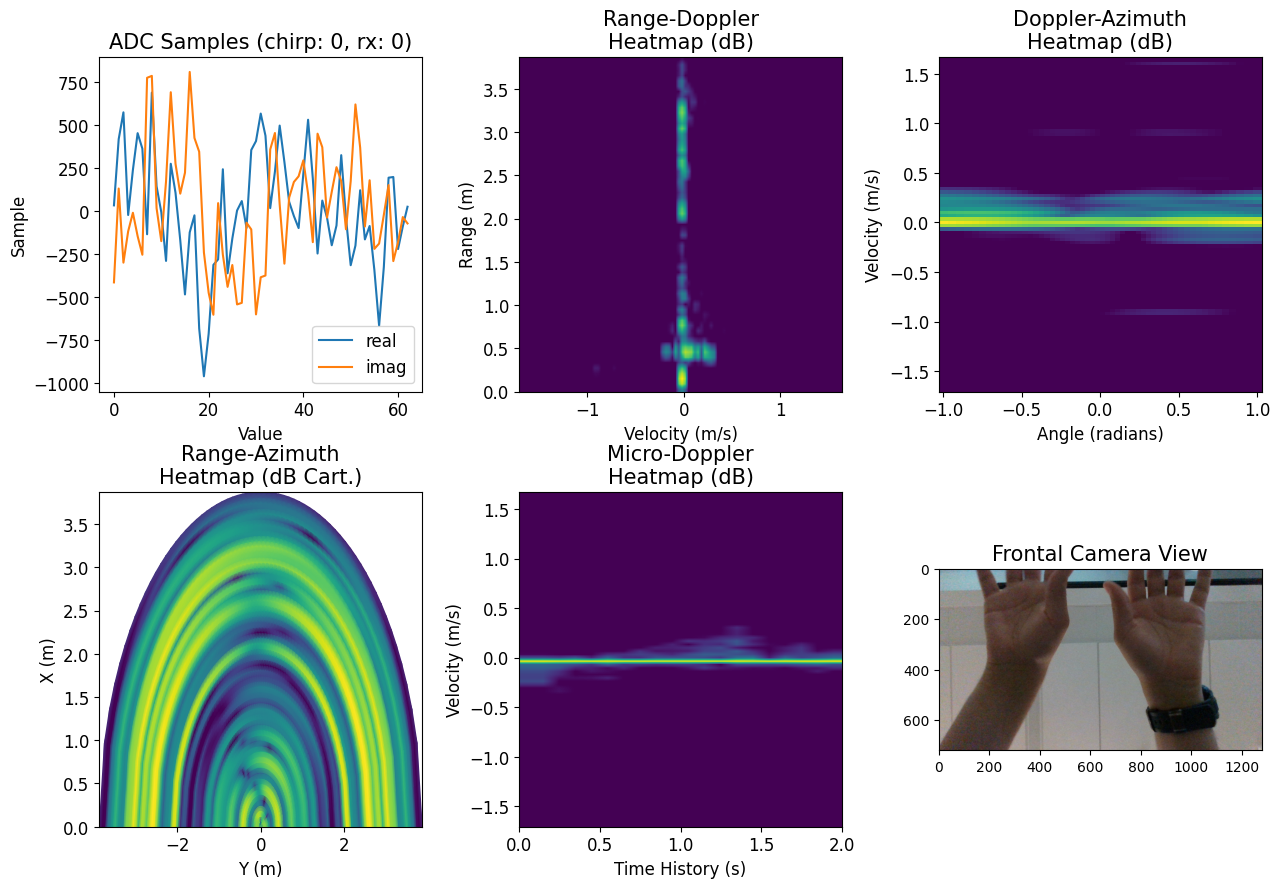

In [5]:
#for getting access to the adc cube
idx=90 - micro_doppler_processor.num_frames_history
#compute responses over a series of frames
for i in range(micro_doppler_processor.num_frames_history):

    #get the ADC cube
    adc_cube = dataset.get_radar_data(idx + i)

    adc_cube = virtual_array_reformatter.process(adc_cube)
    rng_az_resp = range_az_processor.process(adc_cube=adc_cube,chirp_idx=0)
    rng_dop_resp = range_doppler_processor.process(adc_cube=adc_cube,rx_idx=0)
    dop_az_resp = doppler_azimuth_processor.process(adc_cube=adc_cube)
    micro_doppler_resp = micro_doppler_processor.process(adc_cube=adc_cube,rx_idx=0)

    try:
        camera_view = dataset.get_camera_frame(idx + i)
    except AssertionError:
        camera_view = np.empty(shape=(0))

#for generating a compilation of plots
fig,axs=plt.subplots(2,3, figsize=(15,10))
fig.subplots_adjust(wspace=0.3,hspace=0.30)

plotter.plot_compilation(
    adc_cube=adc_cube,
    range_doppler_processor=range_doppler_processor,
    range_azimuth_processor=range_az_processor,
    doppler_azimuth_processor=doppler_azimuth_processor,
    micro_doppler_processor=micro_doppler_processor,
    camera_view=camera_view,
    convert_to_dB=True,
    cmap="viridis",
    chirp_idx=0,
    rx_antenna_idx=0,
    axs=axs,
    show=True
)

adc_cube shape: (12, 63, 100)
rng_azimuth_resp shape: (63, 64)


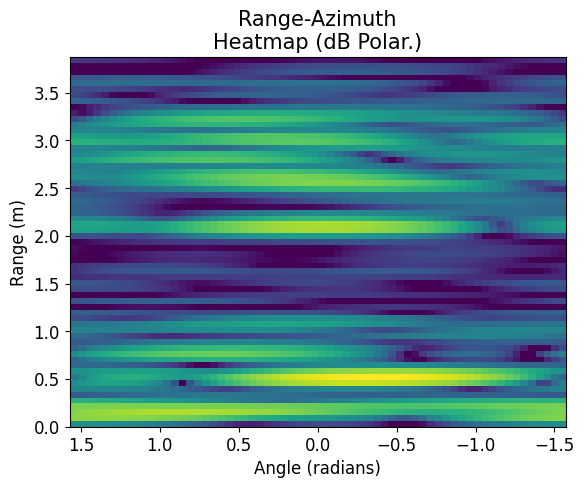

In [16]:
#generating range azimuth plot
#get the ADC cube
adc_cube = dataset.get_radar_data(idx)


if cfg_manager.array_geometry == "ods": #this is the one we are using for the hand tracking
    if cfg_manager.virtual_antennas_enabled: 
        rx_antennas_1 = np.array([0,3,4,7])
        rx_antennas_2 = np.array([1,2,5,6])

adc_cube = virtual_array_reformatter.process(adc_cube)
print(f"adc_cube shape: {adc_cube.shape}")
rng_az_resp = range_az_processor.process(
    adc_cube=adc_cube,
    chirp_idx=0,
    rx_antennas=rx_antennas_1)
print(f"rng_azimuth_resp shape: {rng_az_resp.shape}")


plotter.plot_range_az_resp_polar( #can also use _cart if you want a cartesian plot
    resp=rng_az_resp,
    range_azimuth_processor=range_az_processor,
    convert_to_dB=True,
    show=True
)

adc_cube shape: (12, 63, 100)
rng_elevation_resp shape: (63, 64)


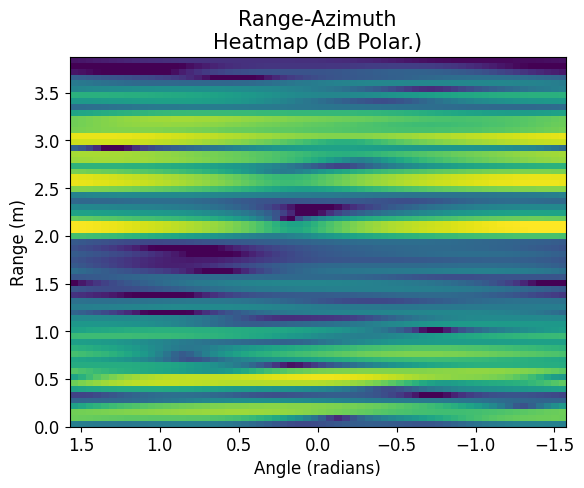

In [ ]:
#generating range elevation plot
#get the ADC cube
adc_cube = dataset.get_radar_data(idx)


if cfg_manager.array_geometry == "ods": #this is the one we are using for the hand tracking
    if cfg_manager.virtual_antennas_enabled: 
        rx_antennas_1 = np.array([10,11,6,7])
        rx_antennas_2 = np.array([9,8,5,4])

adc_cube = virtual_array_reformatter.process(adc_cube)
print(f"adc_cube shape: {adc_cube.shape}")
rng_az_resp = range_az_processor.process(
    adc_cube=adc_cube,
    chirp_idx=0,
    rx_antennas=rx_antennas_1)
print(f"rng_elevation_resp shape: {rng_az_resp.shape}")

plotter.plot_range_az_resp_polar( #can also use _cart if you want a cartesian plot
    resp=rng_az_resp,
    range_azimuth_processor=range_az_processor,
    convert_to_dB=True,
    show=True
)

adc_cube shape: (12, 63, 100)


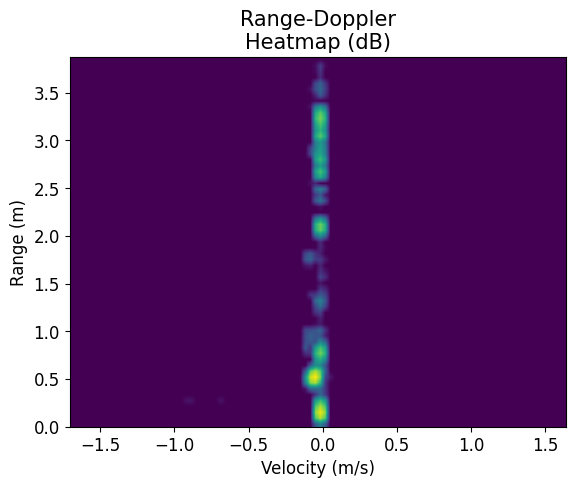

rng_dop_resp shape: (63, 100)


In [18]:
#generating range doppler plot
#get the ADC cube
adc_cube = dataset.get_radar_data(idx)


adc_cube = virtual_array_reformatter.process(adc_cube)
print(f"adc_cube shape: {adc_cube.shape}")

rng_dop_resp = range_doppler_processor.process(adc_cube=adc_cube,rx_idx=0)
plotter.plot_range_doppler_resp(
    resp=rng_dop_resp,
    range_doppler_processor=range_doppler_processor,
    convert_to_dB=True,
    show=True
)

print(f"rng_dop_resp shape: {rng_dop_resp.shape}")

  0%|          | 0/921 [00:00<?, ?it/s]

/home/david/Documents/mmwave_radar_processing/mmwave_radar_processing/plotting/plotter_mmWave_data.py:256: RuntimeWarning: divide by zero encountered in log10
  resp = 20 * np.log10(resp)
100%|██████████| 921/921 [01:18<00:00, 11.66it/s]


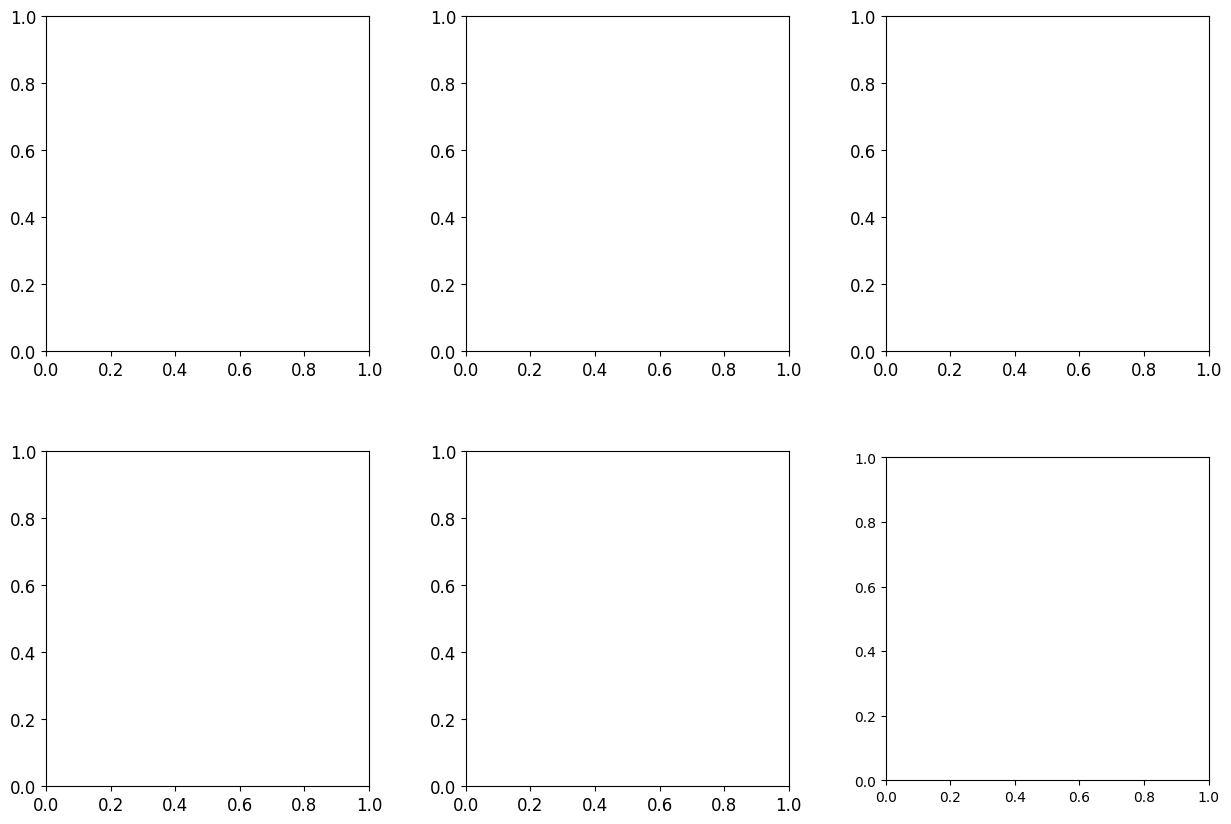

In [6]:
#generate the movie - initialize the figure
movie_generator.initialize_figure(nrows=2,ncols=3,figsize=(15,10))

#reset the microdoppler signature
movie_generator.micro_doppler_processor.micro_doppler_resp = np.zeros_like(movie_generator.micro_doppler_processor.micro_doppler_resp)

#generate the movie frames
movie_generator.generate_movie_frames(
    chirp_idx=0,
    rx_antenna_idx=0,
    cmap="viridis",
    convert_to_dB=True
)

fps = 1 / (1e-3 * cfg_manager.frameCfg_periodicity_ms)
movie_generator.save_movie(video_file_name="{}_raw.mp4".format(dataset_name),fps=fps)

In [7]:
#hand data expressed as follows

# joints = np.array([
#     #Palm position
#     [hand.palm.position.x, hand.palm.position.y, hand.palm.position.z],
#     # Thumb joints
#     [hand.thumb.metacarpal.prev_joint.x, hand.thumb.metacarpal.prev_joint.y, hand.thumb.metacarpal.prev_joint.z],
#     [hand.thumb.metacarpal.next_joint.x, hand.thumb.metacarpal.next_joint.y, hand.thumb.metacarpal.next_joint.z],
#     [hand.thumb.proximal.next_joint.x, hand.thumb.proximal.next_joint.y, hand.thumb.proximal.next_joint.z],
#     [hand.thumb.intermediate.next_joint.x, hand.thumb.intermediate.next_joint.y, hand.thumb.intermediate.next_joint.z],
#     [hand.thumb.distal.next_joint.x, hand.thumb.distal.next_joint.y, hand.thumb.distal.next_joint.z],
#     # Index joints
#     [hand.index.metacarpal.prev_joint.x, hand.index.metacarpal.prev_joint.y, hand.index.metacarpal.prev_joint.z],
#     [hand.index.metacarpal.next_joint.x, hand.index.metacarpal.next_joint.y, hand.index.metacarpal.next_joint.z],
#     [hand.index.proximal.next_joint.x, hand.index.proximal.next_joint.y, hand.index.proximal.next_joint.z],
#     [hand.index.intermediate.next_joint.x, hand.index.intermediate.next_joint.y, hand.index.intermediate.next_joint.z],
#     [hand.index.distal.next_joint.x, hand.index.distal.next_joint.y, hand.index.distal.next_joint.z],
#     # Middle joints
#     [hand.middle.metacarpal.prev_joint.x, hand.middle.metacarpal.prev_joint.y, hand.middle.metacarpal.prev_joint.z],
#     [hand.middle.metacarpal.next_joint.x, hand.middle.metacarpal.next_joint.y, hand.middle.metacarpal.next_joint.z],
#     [hand.middle.proximal.next_joint.x, hand.middle.proximal.next_joint.y, hand.middle.proximal.next_joint.z],
#     [hand.middle.intermediate.next_joint.x, hand.middle.intermediate.next_joint.y, hand.middle.intermediate.next_joint.z],
#     [hand.middle.distal.next_joint.x, hand.middle.distal.next_joint.y, hand.middle.distal.next_joint.z],
#     # Ring joints
#     [hand.ring.metacarpal.prev_joint.x, hand.ring.metacarpal.prev_joint.y, hand.ring.metacarpal.prev_joint.z],
#     [hand.ring.metacarpal.next_joint.x, hand.ring.metacarpal.next_joint.y, hand.ring.metacarpal.next_joint.z],
#     [hand.ring.proximal.next_joint.x, hand.ring.proximal.next_joint.y, hand.ring.proximal.next_joint.z],
#     [hand.ring.intermediate.next_joint.x, hand.ring.intermediate.next_joint.y, hand.ring.intermediate.next_joint.z],
#     [hand.ring.distal.next_joint.x, hand.ring.distal.next_joint.y, hand.ring.distal.next_joint.z],
#     # Pinky joints
#     [hand.pinky.metacarpal.prev_joint.x, hand.pinky.metacarpal.prev_joint.y, hand.pinky.metacarpal.prev_joint.z],
#     [hand.pinky.metacarpal.next_joint.x, hand.pinky.metacarpal.next_joint.y, hand.pinky.metacarpal.next_joint.z],
#     [hand.pinky.proximal.next_joint.x, hand.pinky.proximal.next_joint.y, hand.pinky.proximal.next_joint.z],
#     [hand.pinky.intermediate.next_joint.x, hand.pinky.intermediate.next_joint.y, hand.pinky.intermediate.next_joint.z],
#     [hand.pinky.distal.next_joint.x, hand.pinky.distal.next_joint.y, hand.pinky.distal.next_joint.z],
# ])

(2, 26, 3)


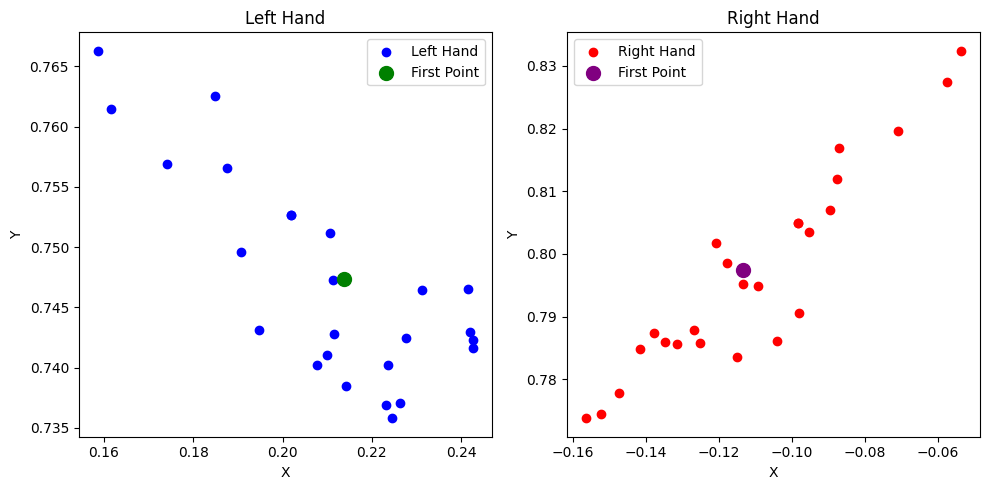

In [8]:
#get hand tracking data
idx = 10

hand_data = dataset.get_hand_tracking_data(idx)
left_hand = hand_data[0,:,:]
right_hand = hand_data[1,:,:]
print(hand_data.shape)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot left hand data
axs[0].scatter(left_hand[:, 0], left_hand[:, 1], c='blue', label='Left Hand')
axs[0].scatter(left_hand[0, 0], left_hand[0, 1], c='green', s=100, label='First Point')
axs[0].set_title('Left Hand')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].legend()

# Plot right hand data
axs[1].scatter(right_hand[:, 0], right_hand[:, 1], c='red', label='Right Hand')
axs[1].scatter(right_hand[0, 0], right_hand[0, 1], c='purple', s=100, label='First Point')
axs[1].set_title('Right Hand')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].legend()

plt.tight_layout()
plt.show()

